
# Statistická práce (Vliv CT opening-killu na pravděpodobnost výhry kola v Counter-Strike 2)
*Pravděpodobnost a statistika 1 (NMAI059) - LS 2024/25*

- **Autor**: Jakub Kos

## Úvod
Counter-Strike 2 je týmová taktická střílečka, v níž se proti sobě utkávají teroristé (T side) a protiteroristická jednotka (CT side) v krátkých kolech na různých mapách. Hráči se snaží splnit specifické cíle (položení nebo zneškodnění bomby) či eliminovat soupeře, přičemž zásadní roli hraje spolupráce, přesnost a strategie.

V této práci se zaměřuji na význam tzv. *opening killu*  – první eliminace v kole – a jeho vliv na výsledek kola. Konkrétně zkoumám, zda získání opening killu protiteroristickou stranou skutečně zvyšuje pravděpodobnost jejího vítězství. CT strana je v centru analýzy proto, že na začátku kola se typicky rozmístí do obranných pozic, zatímco T strana soustředí své úsilí na průnik k jedinému cíli. V důsledku toho bývá opening kill ze strany T obvykle silným prediktorem výhry, zatímco vliv opening killu ze strany CT není zcela jednoznačný a stojí za bližší zkoumání.

## Cíle
- Zjistit, jak silně **opening kill** (dále v textu jako OK) souvisí s výhrou kola.
- Porovnat efekt **po mapách**.
- Ověřit, zda **loadout (AWP = typ zbraně)** souvisí s:
    - (a) šancí získat OK
    - (b) „**conversion**“ – tj. proměna OK ve výhru kola.
- Bonus: krátké **časové analýzy** (OK timing, trade latence).
> Trade ve videohrách označuje situaci, kdy hráč zabije soupeře, ale je krátce poté eliminován jiným protihráčem, takže oba týmy přijdou o jednoho hráče.

## Data
- **Zdroj**: HLTV.org
- **Získání**: Vlstní script
- **Rozsah**: profesionální zápasy CS2 od 1. 1. 2024 do 30. 6. 2025
- **Data**: `warehouse.sqlite` – tabulky `rounds`, `kills_slim`, `round_loadouts`, `events_bomb`, `events_grenades`, `header`.

### Rychlý přehled dat
Pro tuto práci jsem připravil data z profesionálních zápasů hry CS2. Postupoval jsem v následujících krocích:
TODO

Tento notebook se připojuje k `data/warehouse.sqlite` a následně ukazuje:
- **Počty řádků** pro každou tabulku.
- **Co** každá tabulka reprezentuje a **klíčové sloupce**.
- Kompaktní souhrny pro zápasy/dema/mapy/koly/hráče.
- Rychlou tabulku **„souhrnných celkových hodnot“**.

In [78]:
from pathlib import Path
import sqlite3, pandas as pd

DB = Path("data/warehouse.sqlite")
assert DB.exists(), f"Missing warehouse at {DB.resolve()}"

con = sqlite3.connect(DB)

def table_exists(name: str) -> bool:
    return pd.read_sql("SELECT 1 FROM sqlite_master WHERE type='table' AND name=?", con, params=(name,)).shape[0] > 0

def nrows(name: str):
    if not table_exists(name): return None
    return int(pd.read_sql(f"SELECT COUNT(*) AS n FROM {name}", con)["n"].iloc[0])

catalog = pd.DataFrame([
    # table,                     contains (granularity),                              keys (join/use),                                notable fields
    ("header",              "1 row per demo header / map",                        "match_id, demo_file",                          "map_name, tickrate, header_json"),
    ("rounds",              "1 row per round with tick bounds",                   "match_id, demo_file, round",                  "winner, start, end"),
    ("kills_slim",          "1 row per kill",                                     "match_id, demo_file, round",                  "killerSteamID, victimSteamID, weapon, headshot, tick, x/y/z"),
    ("events_shots",        "1 row per shot (unique event_id)",                   "event_id; match_id, demo_file, round",        "shooterSteamID, weapon, tick, t_round, t_sec, x/y/z"),
    ("events_grenades",     "1 row per projectile instance (unique event_id)",    "event_id; match_id, demo_file, round",        "grenadeType, throwerSteamID, grenadeId"),
    ("grenades_summary",    "1 row per thrown grenade (start→end)",               "match_id, demo_file, round",                  "grenadeType, throwerSteamID, start_tick, end_tick"),
    ("events_bomb",         "1 row per bomb event",                               "event_id; match_id, demo_file, round",        "event(planted/defused/explode), site, playerName/SteamID, t_sec"),
    ("round_loadouts",      "1 snapshot per player per round (post-freeze)",      "match_id, demo_file, round, steamid",         "team, name, health, armor, has_helmet, inventory_json"),
    ("round_loadout_items", "1 row per item in that snapshot (exploded)",         "match_id, demo_file, round, steamid, item",   "item, row_id"),
], columns=["table","contains","keys","notables"])

catalog["rows"] = catalog["table"].apply(nrows)
catalog = catalog.sort_values(["rows","table"], ascending=[False, True]).reset_index(drop=True)
catalog[["table","rows","contains","keys","notables"]]

,table,rows,contains,keys,notables
0,events_shots,"591,079.000",1 row per shot (unique event_id),"event_id; match_id, demo_file, round","shooterSteamID, weapon, tick, t_round, t_sec, ..."
1,grenades_summary,"76,823.000",1 row per thrown grenade (start→end),"match_id, demo_file, round","grenadeType, throwerSteamID, start_tick, end_tick"
2,events_grenades,"74,508.000",1 row per projectile instance (unique event_id),"event_id; match_id, demo_file, round","grenadeType, throwerSteamID, grenadeId"
3,round_loadouts,"38,890.000",1 snapshot per player per round (post-freeze),"match_id, demo_file, round, steamid","team, name, health, armor, has_helmet, invento..."
4,kills_slim,"27,736.000",1 row per kill,"match_id, demo_file, round","killerSteamID, victimSteamID, weapon, headshot..."
5,rounds,"4,000.000",1 row per round with tick bounds,"match_id, demo_file, round","winner, start, end"
6,events_bomb,"3,481.000",1 row per bomb event,"event_id; match_id, demo_file, round","event(planted/defused/explode), site, playerNa..."
7,header,186.000,1 row per demo header / map,"match_id, demo_file","map_name, tickrate, header_json"
8,round_loadout_items,NaN,1 row per item in that snapshot (exploded),"match_id, demo_file, round, steamid, item","item, row_id"


In [79]:
def one(sql):
    try: return int(pd.read_sql(sql, con).iloc[0,0])
    except: return 0

entities = pd.DataFrame([
    ("matches", one("SELECT COUNT(DISTINCT match_id) FROM rounds")),
    ("demos",   one("SELECT COUNT(DISTINCT demo_file) FROM header")),
    ("maps",    one("SELECT COUNT(DISTINCT map_name) FROM rounds")),
    ("rounds",  one("SELECT COUNT(*) FROM rounds")),
    ("players", one("SELECT COUNT(DISTINCT steamid) FROM round_loadouts")),
], columns=["entity","count"])

entities

,entity,count
0,matches,78
1,demos,180
2,maps,9
3,rounds,4000
4,players,369


# Pár náhodných analýz na úvod
Původně jsem měl v plánu zaměřit se výhradně na opening kills. Při zpracování dat jsem ale dospěl k závěru, že by byla škoda jejich potenciál nevyužít naplno. Datové soubory, s nimiž pracuji, mají typicky velikost 500–1500 MB (= jeden zápas), protože obsahují záznamy každého ticku (události) zápasu, kterých je přibližně 64 za sekundu. Takto detailní záznam poskytuje obrovské množství informací, z něhož lze vytěžit mnoho různých analýz. Abych se tedy neomezil pouze na původní záměr, zařadil jsem na úvod i několik menších, doplňkových analýz.

## H1: Helma snižuje podíl úmrtí headshotem
**H0**: Podíl killů s headshot=1 je stejný u obětí s helmou i bez helmy (stav po freeze-time).

**Test**: 2×2 (helmet × headshot) → χ² + Fisher;
> Pozn.: stav helmy je snapshot po freeze — v průběhu kola se může změnit, ale hypothesis je i tak užitečná a měřitelná.

Kontingenční tabulka (počty kills):
               No headshot  Headshot  Σ řádek
Bez helmy (0)         4351      5923    10274
S helmou (1)          9227      8235    17462
Σ sloupec            13578     14158    27736

Míry (podíl headshotů + Wilson 95% CI):
                   N  Headshoty  Headshot rate (%)  CI 95% lo (%)  CI 95% hi (%)
Bez helmy (0)  10274       5923             57.650         56.692         58.603
S helmou (1)   17462       8235             47.160         46.420         47.901

Testy:
Chi² = 284.459 (df=1), p = 8.016e-64  →  ZAMÍTÁME H0 (α=0.05)
Fisher OR = 0.656 (95% CI: 0.624–0.689), p = 4.903e-64  →  ZAMÍTÁME H0


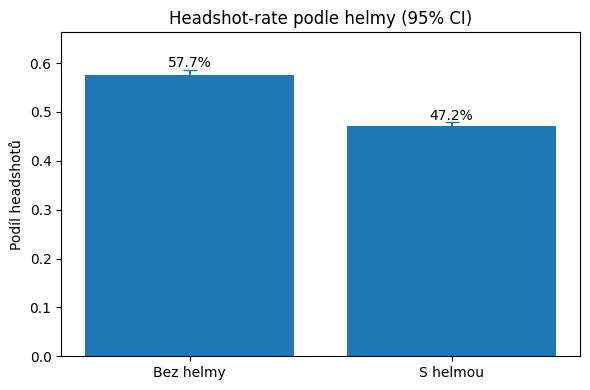

In [80]:
# H2 — Helma vs headshot (čistý výstup, tabulky, graf, závěr)
import sqlite3, pandas as pd, numpy as np
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt

DB_PATH = "data/warehouse.sqlite"  # ← změň podle sebe

with sqlite3.connect(DB_PATH) as con:
    kills = pd.read_sql("""
        SELECT match_id, demo_file, round, victimSteamID, headshot
        FROM kills_slim
    """, con)
    load = pd.read_sql("""
        SELECT match_id, demo_file, round, steamid, has_helmet
        FROM round_loadouts
    """, con)

# Připrav flagy
kills["headshot"]   = pd.to_numeric(kills["headshot"], errors="coerce").fillna(0).astype(int)
load["has_helmet"]  = pd.to_numeric(load["has_helmet"], errors="coerce").fillna(0).astype(int)

# Join: k oběti v daném kole přiřadíme stav helmy (snapshot po freeze)
D = kills.merge(
    load.rename(columns={"steamid":"victimSteamID"}),
    on=["match_id","demo_file","round","victimSteamID"],
    how="left"
).dropna(subset=["has_helmet"])

# 2×2 kontingenční tabulka v pořadí index/columns = [0,1]
tab = pd.crosstab(D["has_helmet"], D["headshot"]).reindex(index=[0,1], columns=[0,1], fill_value=0)

# --- Testy
chi2, p_chi2, dof, exp = chi2_contingency(tab.values)
or_fisher, p_fisher = fisher_exact(tab.values)  # matice [[noHelmet noHS, noHelmet HS],[Helmet noHS, Helmet HS]]

# --- Míry, Wilsonovy 95% CI
def wilson_ci(k, n, z=1.96):
    k, n = float(k), float(n)
    if n <= 0: return (np.nan, np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n))/denom
    half   = z*np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
    return (p, center - half, center + half)

# Počty pro každou skupinu
n0 = tab.loc[0].sum(); hs0 = tab.loc[0,1]; nohs0 = tab.loc[0,0]
n1 = tab.loc[1].sum(); hs1 = tab.loc[1,1]; nohs1 = tab.loc[1,0]

p0, lo0, hi0 = wilson_ci(hs0, n0)
p1, lo1, hi1 = wilson_ci(hs1, n1)

# OR (stejné uspořádání jako u fisher_exact výše): [[b, a],[d, c]]
b, a = nohs0, hs0
d, c = nohs1, hs1
OR = (b*c) / max(1, a*d)
se_logOR = np.sqrt(1/max(1,b) + 1/max(1,a) + 1/max(1,d) + 1/max(1,c))
OR_lo, OR_hi = np.exp(np.log(OR) - 1.96*se_logOR), np.exp(np.log(OR) + 1.96*se_logOR)

# --- Hezké tabulky
ct = tab.copy()
ct.columns = ["No headshot", "Headshot"]
ct.index   = ["Bez helmy (0)", "S helmou (1)"]
ct["Σ řádek"] = ct.sum(axis=1)
ct.loc["Σ sloupec"] = ct.sum()

rates = pd.DataFrame({
    "N":      [n0, n1],
    "Headshoty": [hs0, hs1],
    "Headshot rate": [p0, p1],
    "CI 95% lo": [lo0, lo1],
    "CI 95% hi": [hi0, hi1],
}, index=["Bez helmy (0)", "S helmou (1)"])

pd.options.display.float_format = '{:,.3f}'.format  # pro kompaktnější tisk

print("Kontingenční tabulka (počty kills):")
print(ct.to_string())
print("\nMíry (podíl headshotů + Wilson 95% CI):")
print((rates.assign(**{
    "Headshot rate (%)": lambda d: d["Headshot rate"]*100,
    "CI 95% lo (%)":     lambda d: d["CI 95% lo"]*100,
    "CI 95% hi (%)":     lambda d: d["CI 95% hi"]*100,
}).drop(columns=["Headshot rate","CI 95% lo","CI 95% hi"]).to_string()))

# --- Testové statistiky + rozhodnutí
alpha = 0.05
print("\nTesty:")
print(f"Chi² = {chi2:.3f} (df={dof}), p = {p_chi2:.3e}  →  {'ZAMÍTÁME H0' if p_chi2<alpha else 'NEZAMÍTÁME H0'} (α=0.05)")
print(f"Fisher OR = {or_fisher:.3f} (95% CI: {OR_lo:.3f}–{OR_hi:.3f}), p = {p_fisher:.3e}  →  {'ZAMÍTÁME H0' if p_fisher<alpha else 'NEZAMÍTÁME H0'}")

# --- Graf: headshot-rate s 95% CI
vals = np.array([p0, p1])
yerr = np.array([[p0-lo0, p1-lo1], [hi0-p0, hi1-p1]])  # asymetrické CI
labels = ["Bez helmy", "S helmou"]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals)
plt.errorbar(np.arange(len(vals)), vals, yerr=yerr, fmt='none', capsize=5)
plt.ylabel("Podíl headshotů")
plt.title("Headshot-rate podle helmy (95% CI)")
plt.ylim(0, max(0.01, vals.max()*1.15))
for i, v in enumerate(vals):
    plt.text(i, v + (yerr[1,i] if np.isfinite(yerr[1,i]) else 0) + 0.005, f"{v*100:.1f}%", ha='center')
plt.tight_layout()
plt.show()

### Závěr
Helma výrazně snižuje pravděpodobnost smrti headshotem. Efekt je statisticky velmi významný (≈ 10.5% absolutně).

---

## H2: Bomb plant prodlužuje kolo
> Tato hypotéza se může jevit jako jasná, kolo má maximálně 1 minutu a 55 vteřin, při položení bomby se čas změní na max. 40 vteřin. Ale bomba tímto může kolo dokonce i zkrátit pokut "plant" nastane před časem 40 sekund do konce kola.

**H0**: Délka kola je stejná s plantem i bez plantu.

**Test**: převod ticks → sekundy pomocí tickrate (z header), pak Mann–Whitney U (případně i t-test u velkých n).

Souhrnné statistiky (sekundy):
                     n  mean_s  std_s   q1_s  median_s   q3_s
No plant (0) 1,821.000  47.797 19.410 34.055    45.953 58.914
Plant (1)    2,401.000  59.423 18.854 46.641    57.930 69.617

Test a efektové míry:
 n(with plant)  n(no plant)  U (two-sided)  p (two-sided)  Median diff (s)  CLES = P(plant > no-plant)  Rank-biserial r
          2401         1821  3,029,818.000          0.000           11.977                       0.693            0.386

Závěr (α=0.05):
- Mann–Whitney U p = 1.278e-102  →  ZAMÍTÁME H0 (plant prodlužuje kolo)
- Mediánový rozdíl: 11.98 s (kladné = plant delší)


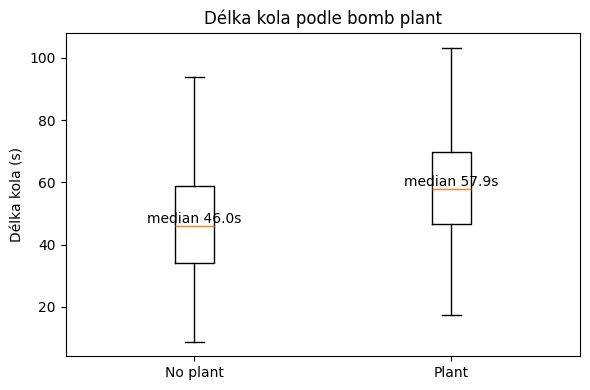

In [81]:
# H2 — Plant vs délka kola (tabulky, graf, závěr)
import sqlite3, pandas as pd, numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

DB_PATH = "data/warehouse.sqlite"  # ← změň podle sebe

# ---------- Načtení a příprava dat ----------
with sqlite3.connect(DB_PATH) as con:
    header = pd.read_sql("SELECT match_id, demo_file, tickrate FROM header", con)
    rounds = pd.read_sql("SELECT match_id, demo_file, round, start, end FROM rounds", con)
    bomb   = pd.read_sql("""
        SELECT match_id, demo_file, round, LOWER(event) AS event
        FROM events_bomb
    """, con)

# Flag plantu v kole
plants = (bomb.query("event == 'planted'")
              .drop_duplicates(["match_id","demo_file","round"])
              .assign(planted=1)[["match_id","demo_file","round","planted"]])

R = (rounds.merge(header, on=["match_id","demo_file"], how="left")
            .merge(plants, on=["match_id","demo_file","round"], how="left")
            .fillna({"planted":0})
            .dropna(subset=["start","end","tickrate"]))

# Délka v sekundách
R = R.assign(dur_s=(R["end"] - R["start"]) / R["tickrate"])

with_plant = R.loc[R["planted"]==1, "dur_s"].to_numpy()
no_plant   = R.loc[R["planted"]==0, "dur_s"].to_numpy()

n1, n0 = len(with_plant), len(no_plant)
if n1 == 0 or n0 == 0:
    raise ValueError("Chybí data v jedné z větví (plant/no-plant).")

# ---------- Souhrnná tabulka ----------
def five_num(x):
    x = np.asarray(x)
    return pd.Series({
        "n": len(x),
        "mean_s": np.mean(x),
        "std_s": np.std(x, ddof=1) if len(x) > 1 else np.nan,
        "q1_s": np.percentile(x, 25),
        "median_s": np.median(x),
        "q3_s": np.percentile(x, 75),
    })

summary = pd.concat([
    five_num(no_plant).rename("No plant (0)"),
    five_num(with_plant).rename("Plant (1)")
], axis=1).T

# rozdíl mediánů (plant − no-plant)
median_diff = np.median(with_plant) - np.median(no_plant)

# ---------- Test + efektová míra ----------
# Mann–Whitney U: p-value z dvoustranné varianty
u_two, p_two = mannwhitneyu(with_plant, no_plant, alternative="two-sided")

# Pro efektové míry potřebujeme U pro hypotézu "plant > no-plant"
u_greater, p_greater = mannwhitneyu(with_plant, no_plant, alternative="greater")
N = n1 * n0

# Common Language Effect Size = P(X>Y) + 0.5 P(X=Y) ~ U/N
cles = u_greater / N

# Rank-biserial correlation (RBC) = 2*U/N - 1  (pro směr "plant delší než no-plant")
rbc = 2*(u_greater/N) - 1

# ---------- Hezký tisk tabulek ----------
pd.options.display.float_format = '{:,.3f}'.format

print("Souhrnné statistiky (sekundy):")
print(summary.to_string())

eff = pd.DataFrame({
    "n(with plant)": [n1],
    "n(no plant)":  [n0],
    "U (two-sided)": [u_two],
    "p (two-sided)": [p_two],
    "Median diff (s)": [median_diff],
    "CLES = P(plant > no-plant)": [cles],
    "Rank-biserial r": [rbc],
})
print("\nTest a efektové míry:")
print(eff.to_string(index=False))

# ---------- Rozhodnutí ----------
alpha = 0.05
print("\nZávěr (α=0.05):")
print(f"- Mann–Whitney U p = {p_two:.3e}  →  {'ZAMÍTÁME H0 (plant prodlužuje kolo)' if p_two < alpha else 'NEZAMÍTÁME H0'}")
print(f"- Mediánový rozdíl: {median_diff:.2f} s (kladné = plant delší)")

# ---------- Graf: boxplot bez outlierů ----------
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot([no_plant, with_plant], showfliers=False)
ax.set_xticks([1,2]); ax.set_xticklabels(["No plant", "Plant"])
ax.set_ylabel("Délka kola (s)")
ax.set_title("Délka kola podle bomb plant")
# doplníme popisky mediánů
med_no = np.median(no_plant); med_pl = np.median(with_plant)
ax.text(1, med_no, f"median {med_no:.1f}s", ha="center", va="bottom")
ax.text(2, med_pl, f"median {med_pl:.1f}s", ha="center", va="bottom")
plt.tight_layout()
plt.show()

Per-map srovnání (mediány v sekundách):
        map  n_plant  n_no  med_plant_s  med_no_s  diff_med_s  p_mwu sig
 de_inferno      391   281        62.92     49.74       13.18   0.00 ***
    de_nuke      341   341        56.06     43.57       12.49   0.00 ***
 de_ancient      546   347        53.46     41.49       11.97   0.00 ***
  de_mirage      396   324        56.19     45.35       10.84   0.00 ***
de_overpass       27    27        69.72     59.10       10.62   0.00  **
   de_dust2      294   221        57.23     47.34        9.88   0.00 ***
  de_anubis      300   189        58.27     49.15        9.12   0.00 ***
 de_vertigo       87    66        60.16     52.20        7.96   0.00  **
   de_train       19    25        59.59     56.03        3.56   0.08    


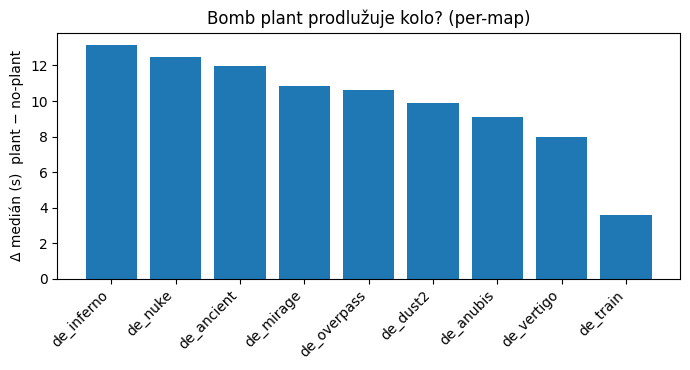

In [82]:
# Per-map: bomb plant prodlužuje kolo? (krátká verze)
import sqlite3, pandas as pd, numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

DB_PATH = "data/warehouse.sqlite"

with sqlite3.connect(DB_PATH) as con:
    header = pd.read_sql("SELECT match_id, demo_file, map_name, tickrate FROM header", con)
    rounds = pd.read_sql("SELECT match_id, demo_file, round, start, end FROM rounds", con)
    bomb   = pd.read_sql("SELECT match_id, demo_file, round, LOWER(event) AS event FROM events_bomb", con)

plants = (bomb.query("event == 'planted'")
              .drop_duplicates(["match_id","demo_file","round"])
              .assign(planted=1)[["match_id","demo_file","round","planted"]])

R = (rounds.merge(header, on=["match_id","demo_file"], how="left")
            .merge(plants, on=["match_id","demo_file","round"], how="left")
            .fillna({"planted":0})
            .dropna(subset=["start","end","tickrate","map_name"])
            .assign(dur_s=lambda d: (d["end"]-d["start"])/d["tickrate"]))

rows = []
for m, g in R.groupby("map_name"):
    a = g.loc[g.planted==1, "dur_s"].to_numpy()
    b = g.loc[g.planted==0, "dur_s"].to_numpy()
    if len(a)==0 or len(b)==0: continue
    u, p = mannwhitneyu(a, b, alternative="two-sided")
    diff = float(np.median(a) - np.median(b))
    rows.append({"map": m, "n_plant": len(a), "n_no": len(b),
                 "med_plant_s": np.median(a), "med_no_s": np.median(b),
                 "diff_med_s": diff, "p_mwu": p})

out = (pd.DataFrame(rows)
         .sort_values("diff_med_s", ascending=False)
         .reset_index(drop=True))

def stars(p): return "***" if p<1e-3 else ("**" if p<1e-2 else ("*" if p<0.05 else ""))

# hezký tisk
pd.options.display.float_format = "{:,.2f}".format
if not out.empty:
    print("Per-map srovnání (mediány v sekundách):")
    print(out.assign(sig=out["p_mwu"].map(stars))
             [["map","n_plant","n_no","med_plant_s","med_no_s","diff_med_s","p_mwu","sig"]]
             .to_string(index=False))

    # krátký graf: rozdíl mediánů podle mapy
    plt.figure(figsize=(7,3.8))
    plt.bar(out["map"], out["diff_med_s"])
    plt.ylabel("Δ medián (s)  plant − no-plant")
    plt.title("Bomb plant prodlužuje kolo? (per-map)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Žádná mapa nemá obě větve (plant/no-plant).")

### Závěr
Lze s jistotou tvrdit, že "bomb plant" prodlužuje délku kola. Zároveň lze ale vidět znatelný rozdíl mezi mapami. Nejvíce prodloužené zápasy se jeví ty, které se odehrávají na mapách, které mají Site A a B nejvíce daleko od sebe. To dává smysl, jelikož po plantu se role útočník/obránce otáčí a to znamená, že CT strana musí překonat větší vzdálenost (= delší doba), aby se dostala na druhý Site.

---

## H3: CT a T vyhrávají zhruba stejně
> Na některých mapách bývá přirozený „side bias“, ale celkově přes různé zápasy může být bilance vyrovnaná. Chceme ověřit, zda T vyhrává stejně často jako CT.

**H0**: Podíl výher T je 50 % (CT a T vyhrávají stejně často).

**Test**: binomický test pro \(p_T=0.5\) + 95% Wilsonovo CI. Per-map opakujeme totéž (bez korekce na vícenásobné testy).

In [83]:
# CELKEM: je T-win rate = 50%?
import sqlite3, pandas as pd, numpy as np
from scipy.stats import binomtest

DB_PATH = "data/warehouse.sqlite"  # ← změň podle sebe

with sqlite3.connect(DB_PATH) as con:
    rounds = pd.read_sql("""
        SELECT match_id, demo_file, round, UPPER(COALESCE(winner,'')) AS winner
        FROM rounds
    """, con)

R = rounds[rounds["winner"].isin(["CT","T"])].copy()
n_CT = (R["winner"]=="CT").sum()
n_T  = (R["winner"]=="T").sum()
n    = n_CT + n_T

# binomický test pro H0: p_T = 0.5
res = binomtest(k=n_T, n=n, p=0.5, alternative="two-sided")
pval = res.pvalue
p_hat = n_T / n

# Wilson 95% CI pro p_T
def wilson_ci(k, n, z=1.96):
    if n==0: return (np.nan, np.nan, np.nan)
    p = k/n; denom = 1 + z**2/n
    center = (p + z**2/(2*n))/denom
    half   = z*np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
    return (p, center - half, center + half)

p, lo, hi = wilson_ci(n_T, n)

out = pd.DataFrame({
    "CT wins":[n_CT], "T wins":[n_T], "n":[n],
    "T-rate":[p], "CI95_lo":[lo], "CI95_hi":[hi], "p_binom":[pval]
})
pd.options.display.float_format = "{:,.3f}".format
print(out.assign(**{
    "T-rate (%)":   lambda d: d["T-rate"]*100,
    "CI95_lo (%)":  lambda d: d["CI95_lo"]*100,
    "CI95_hi (%)":  lambda d: d["CI95_hi"]*100
}).drop(columns=["T-rate","CI95_lo","CI95_hi"]).to_string(index=False))

alpha=0.05
print(f"\nZávěr (α=0.05): p = {pval:.3e}  →  {'ZAMÍTÁME H0 (není 50/50)' if pval<alpha else 'NEZAMÍTÁME H0 (≈ vyrovnané)'}")

 CT wins  T wins    n  p_binom  T-rate (%)  CI95_lo (%)  CI95_hi (%)
    1949    2051 4000    0.110      51.275       49.726       52.822

Závěr (α=0.05): p = 1.103e-01  →  NEZAMÍTÁME H0 (≈ vyrovnané)


### Závěr (celkem)
- **CT wins = 1 949, T wins = 2 051, n = 4 000**
- **T-rate = 51.28 %** (95% CI: **49.73–52.82 %**), **p = 0.110**
→ **NEZAMÍTÁME H₀** (≈ vyrovnané).

        map   n  T_wins  T_rate(%)  CI_lo(%)  CI_hi(%)  diff_pp  p_binom sig
  de_anubis 489     283      57.87     53.45     62.17     7.87     0.00 ***
 de_vertigo 153      85      55.56     47.64     63.20     5.56     0.20    
   de_dust2 515     276      53.59     49.27     57.86     3.59     0.11    
 de_ancient 893     471      52.74     49.46     56.00     2.74     0.11    
  de_mirage 720     375      52.08     48.43     55.71     2.08     0.28    
de_overpass  54      27      50.00     37.11     62.89     0.00     1.00    
    de_nuke 682     327      47.95     44.22     51.70    -2.05     0.30    
 de_inferno 672     299      44.49     40.78     48.27    -5.51     0.00  **
   de_train  44      18      40.91     27.69     55.59    -9.09     0.29    


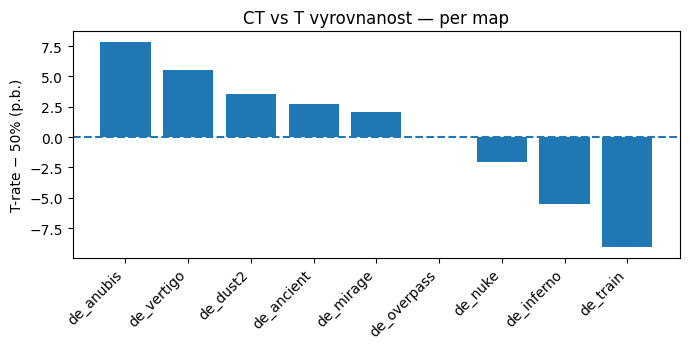

In [84]:
# PER-MAP: je T-win rate = 50% na každé mapě?
import sqlite3, pandas as pd, numpy as np
from scipy.stats import binomtest
import matplotlib.pyplot as plt

DB_PATH = "data/warehouse.sqlite"  # ← změň

with sqlite3.connect(DB_PATH) as con:
    header = pd.read_sql("SELECT match_id, demo_file, map_name FROM header", con)
    rounds = pd.read_sql("SELECT match_id, demo_file, round, UPPER(COALESCE(winner,'')) AS winner FROM rounds", con)

R = (rounds.merge(header, on=["match_id","demo_file"], how="left")
          .dropna(subset=["map_name"])
          .query("winner in ['CT','T']"))

rows=[]
def wilson_ci(k, n, z=1.96):
    if n==0: return (np.nan, np.nan, np.nan)
    p=k/n; denom=1+z**2/n
    center=(p+z**2/(2*n))/denom
    half=z*np.sqrt((p*(1-p)/n)+(z**2/(4*n**2)))/denom
    return (p, center-half, center+half)

for m, g in R.groupby("map_name"):
    n_T = (g["winner"]=="T").sum()
    n   = len(g)
    pval = binomtest(k=n_T, n=n, p=0.5, alternative="two-sided").pvalue
    p, lo, hi = wilson_ci(n_T, n)
    rows.append({"map":m, "n":n, "T_wins":n_T, "T_rate":p, "CI95_lo":lo, "CI95_hi":hi, "p_binom":pval,
                 "diff_pp": (p-0.5)*100})

out = (pd.DataFrame(rows)
         .sort_values("diff_pp", ascending=False)
         .reset_index(drop=True))

def stars(p): return "***" if p<1e-3 else ("**" if p<1e-2 else ("*" if p<0.05 else ""))

pd.options.display.float_format = "{:,.2f}".format
if not out.empty:
    print(out.assign(**{
        "T_rate(%)":  lambda d: d["T_rate"]*100,
        "CI_lo(%)":   lambda d: d["CI95_lo"]*100,
        "CI_hi(%)":   lambda d: d["CI95_hi"]*100,
        "sig":        lambda d: d["p_binom"].map(stars)
    })[["map","n","T_wins","T_rate(%)","CI_lo(%)","CI_hi(%)","diff_pp","p_binom","sig"]]
      .to_string(index=False))

    # volitelný krátký graf: T-rate − 50% (v p.b.)
    plt.figure(figsize=(7,3.6))
    plt.bar(out["map"], out["diff_pp"])
    plt.axhline(0, linestyle="--")
    plt.ylabel("T-rate − 50% (p.b.)")
    plt.title("CT vs T vyrovnanost — per map")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Žádná mapa nemá dostupná kola.")

### Závěr (per map, stručně)
- **de_anubis**: T-rate **57.87 %** (CI 53.45–62.17), **p < 0.001** (**T-sided**, +7.87 p.b.) ***
- **de_inferno**: T-rate **44.49 %** (CI 40.78–48.27), **p < 0.01** (**CT-sided**, −5.51 p.b.) **
- **de_vertigo**: **55.56 %** (CI 47.64–63.20), **p = 0.20** (nesign.)
- **de_dust2**: **53.59 %** (CI 49.27–57.86), **p = 0.11** (nesign.)
- **de_ancient**: **52.74 %** (CI 49.46–56.00), **p = 0.11** (nesign.)
- **de_mirage**: **52.08 %** (CI 48.43–55.71), **p = 0.28** (nesign.)
- **de_nuke**: **47.95 %** (CI 44.22–51.70), **p = 0.30** (nesign.)
- **de_overpass**: **50.00 %** (CI 37.11–62.89), **p = 1.00** (nesign.)
- **de_train**: **40.91 %** (CI 27.69–55.59), **p = 0.29** (nesign., n=44)

---

# Hlavní hypotéza (závislost mezi opening-killem a výhrou kola)

## 0) Helpers

In [85]:
# === Imports & set-up ===
from pathlib import Path
import sqlite3, json, math, sys, warnings
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt

DB_CANDIDATES = [
    Path("warehouse.sqlite"),
    Path("./data/warehouse.sqlite"),
    Path("/mnt/data/warehouse.sqlite"),
]
DB = next((p for p in DB_CANDIDATES if p.exists()), DB_CANDIDATES[-1])

con = sqlite3.connect(DB)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

def read_df(sql: str, params=None) -> pd.DataFrame:
    return pd.read_sql_query(sql, con, params=params)

def or_ci(a, b, c, d):
    # Odds ratio a 95% CI (Woolf; s Haldane-Anscombe 0.5 při nulách).
    a,b,c,d = map(float, (a,b,c,d))
    if min(a,b,c,d) == 0:
        a += 0.5; b += 0.5; c += 0.5; d += 0.5
    OR = (a*d)/(b*c)
    se = math.sqrt(1/a + 1/b + 1/c + 1/d)
    lo = math.exp(math.log(OR) - 1.96*se)
    hi = math.exp(math.log(OR) + 1.96*se)
    return OR, lo, hi

def safe_2x2(tab: pd.DataFrame, rows, cols) -> pd.DataFrame:
    # Doplní chybějící řádky/sloupce a vrátí int 2x2 tabulku v pořadí.
    return (tab.reindex(index=list(rows), columns=list(cols), fill_value=0)
               .astype(int))

def print_2x2_stats(a,b,c,d, label=""):
    M = np.array([[a,b],[c,d]], dtype=float)
    if (M.sum() == 0) or (M[0].sum() == 0) or (M[1].sum() == 0) or (M[:,0].sum() == 0) or (M[:,1].sum() == 0):
        print(label, "Nelze testovat (chybí variace).")
        return
    chi2, p_chi2, dof, exp = chi2_contingency(M)
    OR, lo, hi = or_ci(a,b,c,d)
    _, p_fisher = fisher_exact(M, alternative="two-sided")
    print(f"{label}  OR={OR:.2f} (95% CI {lo:.2f}–{hi:.2f}) | χ² p={p_chi2:.3g} | Fisher p={p_fisher:.3g}")

def annotate_bars(ax):
    # Hodnoty na horní hrany sloupců.
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(f"{int(h)}", (p.get_x()+p.get_width()/2, h), ha="center", va="bottom", fontsize=9)

def get_tickrate_default():
    # Pokus najít tickrate v headeru; fallback 64.
    try:
        hdr = read_df("SELECT * FROM header LIMIT 5")
        cols = [c.lower() for c in hdr.columns]
        cand = None
        for key in ["tickrate", "tick_rate", "tick_rate_hz"]:
            if key in cols:
                cand = float(hdr.iloc[0, cols.index(key)])
                break
        return int(cand if cand and np.isfinite(cand) else 64)
    except Exception:
        return 64

def percentage_labels_from_counts(ax):
    total = sum(p.get_height() for p in ax.patches)
    for p in ax.patches:
        h = p.get_height()
        if total > 0:
            ax.annotate(f"{int(h)}  ({h/total:.0%})",
                        (p.get_x()+p.get_width()/2, h),
                        ha="center", va="bottom", fontsize=9)


## H1: Opening kill a výsledek kola
> Intuitivně by první kill měl přinést výraznou poziční a početní výhodu. Ověříme, zda strana, která získá **opening kill**, skutečně **častěji vyhrává** kolo.

**H0**: Strana vítěze kola je **nezávislá** na straně, která získala opening kill.
**Test**: 2×2 kontingenční tabulka `winner × opening_side` (CT/T) → **χ²** i **Fisher** test; efekt reportujeme jako **odds ratio** (OR) s 95% CI.


Kontingenční tabulka (počty):
           opening=ct  opening=t  Σ řádek
winner=ct        1553        572     2125
winner=t          773       1409     2182
Σ sloupec        2326       1981     4307

Řádkové podíly (%):
           % vs opening=ct  % vs opening=t
winner=ct            73.08           26.92
winner=t             35.43           64.57

Opening-side → výhra kola:  OR=4.95 (95% CI 4.35–5.64) | χ² p=2.432e-135 | Fisher p=4.255e-139
Podíl kol, kde vyhrála opening-side: 68.8%  (2962/4307)


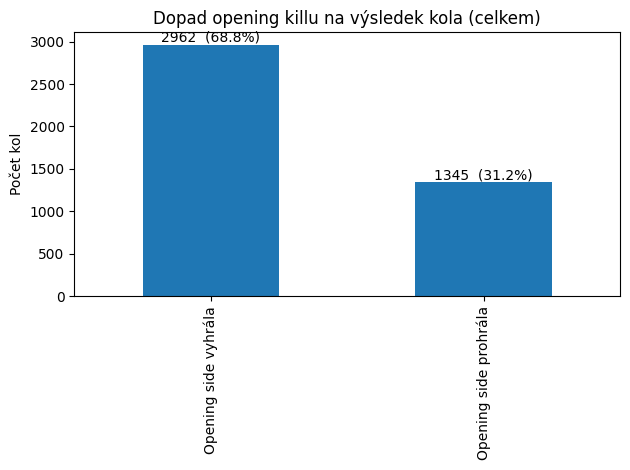

In [86]:
# Opening kill × výhra kola — 2×2 tabulka, testy, graf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# --- Tvoje SQL a načtení (ponecháno beze změn) ---
SQL_OK_WIN = """
WITH first_kill AS (
  SELECT r.match_id, r.demo_file, r.map_name, r.round, r.winner,
         MIN(k.tick) AS first_tick
  FROM rounds r
  JOIN kills_slim k
    ON (r.match_id=k.match_id AND r.demo_file=k.demo_file AND r.round=k.round)
  GROUP BY r.match_id, r.demo_file, r.map_name, r.round, r.winner
),
opening AS (
  SELECT f.match_id, f.demo_file, f.map_name, f.round, f.winner, k.killerSide AS opening_side
  FROM first_kill f
  JOIN kills_slim k
    ON (f.match_id=k.match_id AND f.demo_file=k.demo_file AND f.round=k.round AND f.first_tick=k.tick)
)
SELECT winner, opening_side FROM opening
"""
ok = read_df(SQL_OK_WIN)

# --- Úprava a 2×2 tabulka ---
ok = ok.dropna(subset=["winner","opening_side"]).copy()
ok["winner"] = ok["winner"].str.lower()
ok["opening_side"] = ok["opening_side"].str.lower()
ok = ok[ok["winner"].isin(["ct","t"]) & ok["opening_side"].isin(["ct","t"])]

ct = pd.crosstab(ok["winner"], ok["opening_side"]).reindex(index=["ct","t"], columns=["ct","t"], fill_value=0)

# Přidej součty a řádkovou procentuální matici
ct_pretty = ct.copy()
ct_pretty.columns = ["opening=ct", "opening=t"]
ct_pretty.index   = ["winner=ct",  "winner=t"]
ct_pretty["Σ řádek"] = ct_pretty.sum(axis=1)
ct_pretty.loc["Σ sloupec"] = ct_prety_sum = ct_pretty.sum()

row_pct = (ct.div(ct.sum(axis=1), axis=0)*100).round(2)
row_pct.index = ["winner=ct", "winner=t"]
row_pct.columns = ["% vs opening=ct", "% vs opening=t"]

print("Kontingenční tabulka (počty):")
print(ct_pretty.to_string())
print("\nŘádkové podíly (%):")
print(row_pct.to_string())

# --- Testy + OR s 95% CI (Haldane–Anscombe pro robustnost) ---
a, b, c, d = ct.loc["ct","ct"], ct.loc["ct","t"], ct.loc["t","ct"], ct.loc["t","t"]
aa, bb, cc, dd = map(float, (a, b, c, d))
if min(aa,bb,cc,dd) == 0:
    aa += 0.5; bb += 0.5; cc += 0.5; dd += 0.5  # korekce při nulových buňkách

OR = (aa*dd)/(bb*cc)
se_logOR = np.sqrt(1/aa + 1/bb + 1/cc + 1/dd)
OR_lo, OR_hi = np.exp(np.log(OR) - 1.96*se_logOR), np.exp(np.log(OR) + 1.96*se_logOR)

chi2, p_chi2, dof, exp = chi2_contingency(ct.values)
or_fisher, p_fisher = fisher_exact(ct.values)

# Podíl kol, kde opening side vyhrála (diagonála)
diag = ct.loc["ct","ct"] + ct.loc["t","t"]
total = ct.values.sum()
share_opening_wins = diag / total

print(f"\nOpening-side → výhra kola:  OR={OR:.2f} (95% CI {OR_lo:.2f}–{OR_hi:.2f}) | "
      f"χ² p={p_chi2:.3e} | Fisher p={p_fisher:.3e}")
print(f"Podíl kol, kde vyhrála opening-side: {share_opening_wins*100:.1f}%  ({diag}/{total})")

# --- Graf: kolik kol vyhrála opening-side vs prohrála ---
win_series = (ok["winner"] == ok["opening_side"]).value_counts().rename(
    {True:"Opening side vyhrála", False:"Opening side prohrála"}
).reindex(["Opening side vyhrála","Opening side prohrála"]).fillna(0).astype(int)

ax = win_series.plot.bar()
ax.set_ylabel("Počet kol")
ax.set_title("Dopad opening killu na výsledek kola (celkem)")
for i, v in enumerate(win_series.values):
    pct = v/total*100 if total else 0
    ax.text(i, v, f"{v}  ({pct:.1f}%)", ha="center", va="bottom")
plt.tight_layout(); plt.show()

### Závěr
- **Opening-side vyhrála v 68.8 % kol** (2962 / 4307).
- **OR = 4.95** (95% CI **4.35–5.64**), **χ² p = 2.43×10⁻¹³⁵**, **Fisher p = 4.25×10⁻¹³⁹**.
→ **ZAMÍTÁME H₀**: strana, která získá opening kill, **výrazně častěji vyhrává** kolo.

---

## H2: Opening kill a výsledek kola — per map
> Efekt opening killu se může mezi mapami lišit (jiné rozestavení, délky sightline, frekvence soubojů). Ověříme, zda **na jednotlivých mapách** strana s opening killem **častěji vyhrává** kolo.

**H0**: Na dané mapě je vítězná strana **nezávislá** na straně, která získala opening kill.
**Test**: pro každou mapu 2×2 tabulka (`winner × opening_side`) → **χ²** test, p-hodnoty korigujeme **Holm** metodou; efekt uvádíme jako **odds ratio** (OR) s 95% CI.
**Vizualizace**: forest plot OR (log-osa) s 95% CI, referenční čára OR=1.

        map   n   a   b   c   d  open_wins  open_win_rate(%)              OR_CI  p(chi2)  p(chi2)_holm sig
 de_ancient 886 319 107 163 297        616            69.526   5.43 [4.06–7.26]    0.000         0.000 ***
  de_anubis 469 133  61 102 173        306            65.245   3.70 [2.50–5.46]    0.000         0.000 ***
   de_dust2 569 180  68 107 214        394            69.244   5.29 [3.68–7.61]    0.000         0.000 ***
 de_inferno 657 277  99 112 169        446            67.884   4.22 [3.03–5.88]    0.000         0.000 ***
  de_mirage 751 265 104 145 237        502            66.844   4.16 [3.06–5.66]    0.000         0.000 ***
    de_nuke 697 273 100 102 222        495            71.019   5.94 [4.28–8.25]    0.000         0.000 ***
de_overpass  72  30  15  10  17         47            65.278   3.40 [1.25–9.22]    0.027         0.027   *
   de_train  44  22   4   7  11         33            75.000  8.64 [2.08–35.97]    0.005         0.010  **
 de_vertigo 162  54  14  25  69      

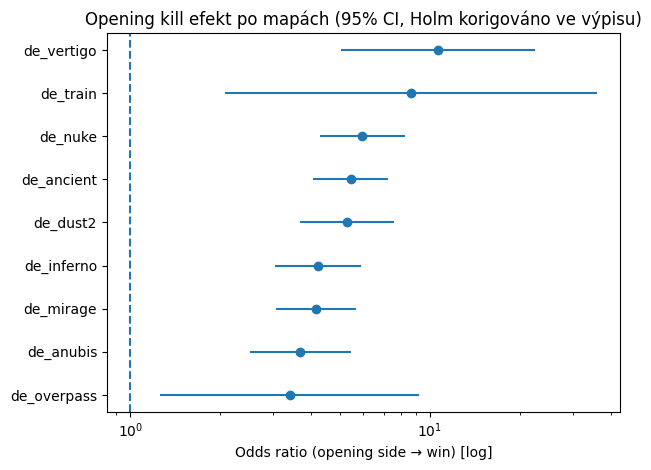

In [87]:
# Opening kill × výhra kola — per-map 2×2, OR (95% CI), χ², Holm, forest plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- SQL beze změn ---
SQL_BY_MAP = """
WITH first_kill AS (
  SELECT r.match_id, r.demo_file, r.map_name, r.round, r.winner,
         MIN(k.tick) AS first_tick
  FROM rounds r
  JOIN kills_slim k
    ON (r.match_id=k.match_id AND r.demo_file=k.demo_file AND r.round=k.round)
  GROUP BY r.match_id, r.demo_file, r.map_name, r.round, r.winner
),
opening AS (
  SELECT f.map_name, f.winner, k.killerSide AS opening_side
  FROM first_kill f
  JOIN kills_slim k
    ON (f.match_id=k.match_id AND f.demo_file=k.demo_file AND f.round=k.round AND f.first_tick=k.tick)
)
SELECT map_name,
  SUM(CASE WHEN winner='ct' AND opening_side='ct' THEN 1 ELSE 0 END) AS a,
  SUM(CASE WHEN winner='ct' AND opening_side='t'  THEN 1 ELSE 0 END) AS b,
  SUM(CASE WHEN winner='t'  AND opening_side='ct' THEN 1 ELSE 0 END) AS c,
  SUM(CASE WHEN winner='t'  AND opening_side='t'  THEN 1 ELSE 0 END) AS d
FROM opening
GROUP BY map_name
"""
by_map = read_df(SQL_BY_MAP).fillna(0)

# --- Pomocné funkce ---
def or_ci_2x2(a,b,c,d):
    """Log-OR CI s Haldane–Anscombe korekcí pro nulové buňky."""
    a,b,c,d = map(float, (a,b,c,d))
    if min(a,b,c,d) == 0:
        a += 0.5; b += 0.5; c += 0.5; d += 0.5
    OR = (a*d)/(b*c)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    lo, hi = np.exp(np.log(OR) - 1.96*se), np.exp(np.log(OR) + 1.96*se)
    return OR, lo, hi

def holm_adjust(pvals):
    p = np.asarray(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)           # vzestupně
    adj = np.empty(m)
    for rank, idx in enumerate(order):
        adj[idx] = min(1.0, p[idx] * (m - rank))
    # zajisti monotonii ve směru od nejmenšího
    adj_sorted = adj[order]
    for i in range(1, m):
        adj_sorted[i] = max(adj_sorted[i], adj_sorted[i-1])
    adj[order] = adj_sorted
    return adj

def stars(p):
    return "***" if p < 1e-3 else ("**" if p < 1e-2 else ("*" if p < 0.05 else ""))

# --- Výpočet per mapu ---
rows = []
for _, r in by_map.iterrows():
    a,b,c,d = int(r.a), int(r.b), int(r.c), int(r.d)
    # χ² (s continuity correction pro 2×2)
    chi2, p_chi2, dof, exp = chi2_contingency([[max(a,0.5),max(b,0.5)],
                                               [max(c,0.5),max(d,0.5)]], correction=True)
    OR, lo, hi = or_ci_2x2(a,b,c,d)
    n_total = a+b+c+d
    opening_win_rate = (a + d) / n_total if n_total else np.nan
    rows.append({
        "map_name": r.map_name,
        "n_total": n_total, "a": a, "b": b, "c": c, "d": d,
        "opening_wins": a+d, "opening_win_rate": opening_win_rate,
        "odds_ratio": OR, "ci95_lo": lo, "ci95_hi": hi,
        "p_chi2": p_chi2
    })

by_map_stats = pd.DataFrame(rows).sort_values("map_name").reset_index(drop=True)
by_map_stats["p_chi2_holm"] = holm_adjust(by_map_stats["p_chi2"].values)
by_map_stats["sig"] = by_map_stats["p_chi2_holm"].map(stars)

# --- Hezký tisk tabulky ---
pd.options.display.float_format = "{:,.3f}".format
pretty = (by_map_stats.assign(
            opening_rate_pct = lambda d: d["opening_win_rate"]*100,
            OR_CI = lambda d: d.apply(lambda x: f"{x['odds_ratio']:.2f} [{x['ci95_lo']:.2f}–{x['ci95_hi']:.2f}]", axis=1)
         )[
    ["map_name","n_total","a","b","c","d","opening_wins","opening_rate_pct","OR_CI","p_chi2","p_chi2_holm","sig"]
].rename(columns={
    "map_name":"map",
    "n_total":"n",
    "opening_wins":"open_wins",
    "opening_rate_pct":"open_win_rate(%)",
    "p_chi2":"p(chi2)",
    "p_chi2_holm":"p(chi2)_holm"
}))
print(pretty.to_string(index=False))

# --- Forest plot (OR s 95% CI; log osa) ---
dfp = by_map_stats.copy().sort_values("odds_ratio")
y = np.arange(len(dfp))
plt.errorbar(dfp["odds_ratio"], y,
             xerr=[dfp["odds_ratio"] - dfp["ci95_lo"], dfp["ci95_hi"] - dfp["odds_ratio"]],
             fmt='o')
plt.axvline(1.0, linestyle="--")
plt.yticks(y, dfp["map_name"])
plt.xscale("log"); plt.xlabel("Odds ratio (opening side → win) [log]")
plt.title("Opening kill efekt po mapách (95% CI, Holm korigováno ve výpisu)")
plt.tight_layout(); plt.show()

### Závěr (per map)
- Na mapách s **p<0.05** pozorujeme **významný pozitivní efekt** opening killu (OR > 1, „opening side“ častěji vyhrává).
- Mapy s **p(chi²)_holm ≥ 0.05** nevykazují průkaznou odchylku (evidence nestačí).
- Velikost efektu se liší napříč mapami (viz OR a 95% CI ve výpisu); obecně ale platí, že **opening kill je silný prediktor** výsledku kola.

---

## H3: AWP na startu zvyšuje šanci být opening-side
> Předpokládáme, že přítomnost AWP (zbraň typu puška, většinou 1-hit-kill) posouvá první souboj ve prospěch týmu s AWP.

**H0**: Pravděpodobnost být *opening-side* je stejná s AWP i bez AWP.
**Test**: 2×2 `AWP present × is_opening_side` → χ² + Fisher; efekt = OR (95% CI).


In [88]:
# AWP → (a) být opening-side, (b) konverze opening-side na výhru
import json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# --- 1) Načtení loadoutů (CT/T) ---
rl = read_df("""
  SELECT match_id, demo_file, round, team, has_helmet, inventory_json
  FROM round_loadouts
  WHERE team IN ('CT','T')
""")

def parse_items(inv_json: str) -> list[str]:
    try:
        return [str(x).lower() for x in json.loads(inv_json)]
    except Exception:
        return []

# Výzbrojní kategorie (token match přes substring)
AWP   = {"awp"}
RIFLE = {"ak-47","ak47","ak","m4a1-s","m4a1s","m4a1","m4a4","famas","galil ar","galil","aug","sg 553","sg553"}
SMG   = {"mp9","mac-10","mac10","mp7","mp5-sd","mp5sd","ump-45","ump45","p90"}
HEAVY = {"nova","xm1014","mag-7","mag7","sawed-off","sawed off","m249","negev"}
PIST  = {"glock-18","glock","usp-s","usps","p2000","p250","fiveseven","five-seven","tec-9","tec9","cz75-auto","cz75a","dual berettas","desert eagle","deagle","r8 revolver","revolver"}

def any_of(tokens, items):  return any(any(tok in it for tok in tokens) for it in items)
def count_of(tokens, items): return sum(1 for it in items if any(tok in it for tok in tokens))

agg=[]
for (mid, dem, rnd, team), g in rl.groupby(["match_id","demo_file","round","team"], dropna=False):
    items = sum((parse_items(x) for x in g["inventory_json"]), [])
    helmets = int(pd.to_numeric(g["has_helmet"], errors="coerce").fillna(0).sum())
    players = int(len(g))
    agg.append(dict(
        match_id=mid, demo_file=dem, round=rnd, team=team,
        awp_present=any_of(AWP, items),
        rifles=count_of(RIFLE, items),
        smgs=count_of(SMG, items),
        heavy=count_of(HEAVY, items),
        pistols=count_of(PIST, items),
        helmet_share=helmets/max(players,1),
        players=players
    ))
team_loadout = pd.DataFrame(agg)

# --- 2) Opening-side a winner (robustně přes first-tick) ---
first = read_df("""
WITH first_tick AS (
  SELECT match_id, demo_file, round, MIN(tick) AS first_tick
  FROM kills_slim
  GROUP BY match_id, demo_file, round
)
SELECT k.match_id, k.demo_file, k.round, k.killerSide AS opening_side, f.first_tick
FROM kills_slim k
JOIN first_tick f
  ON k.match_id=f.match_id AND k.demo_file=f.demo_file AND k.round=f.round AND k.tick=f.first_tick
""")
rnd_winners = read_df("SELECT match_id, demo_file, round, winner FROM rounds")

# Dvě strany na kolo
two = (team_loadout
       .merge(first[["match_id","demo_file","round","opening_side"]], on=["match_id","demo_file","round"], how="inner")
       .merge(rnd_winners, on=["match_id","demo_file","round"], how="inner"))
two["is_opening_side"] = (two["team"] == two["opening_side"].map({"ct":"CT","t":"T"}))
two["won_round"] = (two["team"].str.lower() == two["winner"].str.lower())

# --- Pomůcky pro 2×2 + testy ---
def twobytwo_counts(df, row_col, col_col):
    tab = pd.crosstab(df[row_col].astype(bool), df[col_col].astype(bool)).reindex(index=[False,True], columns=[False,True], fill_value=0)
    a = int(tab.loc[True, True])   # row=True,  col=True
    b = int(tab.loc[True, False])  # row=True,  col=False
    c = int(tab.loc[False,True])   # row=False, col=True
    d = int(tab.loc[False,False])  # row=False, col=False
    return tab, a,b,c,d

def or_ci(a,b,c,d):
    a,b,c,d = map(float, (a,b,c,d))
    if min(a,b,c,d) == 0:  # Haldane–Anscombe
        a+=0.5; b+=0.5; c+=0.5; d+=0.5
    OR = (a*d)/(b*c)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    lo, hi = np.exp(np.log(OR) - 1.96*se), np.exp(np.log(OR) + 1.96*se)
    return OR, lo, hi

def tests_and_pretty(tab, a,b,c,d, row_name, col_name, title):
    # Tisk počtů + řádkových podílů
    tp = tab.copy()
    tp.columns = [f"{col_name}=False", f"{col_name}=True"]
    tp.index   = [f"{row_name}=False", f"{row_name}=True"]
    tp["Σ řádek"] = tp.sum(axis=1)
    tp.loc["Σ sloupec"] = tp.sum()
    print(title)
    print(tp.to_string(), "\n")

    row_pct = (tab.div(tab.sum(axis=1), axis=0)*100).round(2)
    row_pct.index = [f"{row_name}=False", f"{row_name}=True"]
    row_pct.columns = [f"% {col_name}=False", f"% {col_name}=True"]
    print("Řádkové podíly (%):")
    print(row_pct.to_string(), "\n")

    # Testy
    chi2, p_chi2, dof, exp = chi2_contingency(tab.values)  # bez continuity, 2×2 OK
    or_f, p_f = fisher_exact(tab.values)
    OR, lo, hi = or_ci(a,b,c,d)
    print(f"OR={OR:.2f} (95% CI {lo:.2f}–{hi:.2f}) | χ² p={p_chi2:.3e} | Fisher p={p_f:.3e}\n")
    return OR, lo, hi, p_chi2, p_f

def bar_counts(series, title, ylabel):
    ax = series.rename({True:"True", False:"False"}).reindex(["True","False"]).fillna(0).astype(int).plot.bar()
    ax.set_title(title); ax.set_ylabel(ylabel)
    total = series.sum()
    for i, v in enumerate(series.reindex([True, False]).fillna(0).astype(int).values):
        pct = v/total*100 if total else 0
        ax.text(i, v, f"{v} ({pct:.1f}%)", ha="center", va="bottom")
    plt.tight_layout(); plt.show()

# --- (a) AWP → být opening-side ---
tab_open, a1,b1,c1,d1 = twobytwo_counts(two, row_col="awp_present", col_col="is_opening_side")
OR1, lo1, hi1, pchi1, pf1 = tests_and_pretty(tab_open, a1,b1,c1,d1, row_name="AWP present", col_name="is_opening_side",
                                             title="(a) Kontingenční tabulka: AWP present × is_opening_side")

# --- (b) AWP u opening-side → výhra kola (conversion) ---
ok = (rnd_winners.merge(first[["match_id","demo_file","round","opening_side"]],
                        on=["match_id","demo_file","round"], how="inner"))
ok["open_team"] = ok["opening_side"].map({"ct":"CT","t":"T"})

ds = ok.merge(team_loadout, left_on=["match_id","demo_file","round","open_team"],
              right_on=["match_id","demo_file","round","team"], how="left")
ds["opening_won"] = (ds["winner"].str.lower() == ds["opening_side"])

tab_conv, a2,b2,c2,d2 = twobytwo_counts(ds, row_col="awp_present", col_col="opening_won")
OR2, lo2, hi2, pchi2, pf2 = tests_and_pretty(tab_conv, a2,b2,c2,d2, row_name="AWP present (opening-side)", col_name="opening_won",
                                             title="(b) Kontingenční tabulka: AWP (opening-side) × opening_won")

(a) Kontingenční tabulka: AWP present × is_opening_side
                   is_opening_side=False  is_opening_side=True  Σ řádek
AWP present=False                   2987                  2670     5657
AWP present=True                    1576                  1877     3453
Σ sloupec                           4563                  4547     9110 

Řádkové podíly (%):
                   % is_opening_side=False  % is_opening_side=True
AWP present=False                   52.800                  47.200
AWP present=True                    45.640                  54.360 

OR=1.33 (95% CI 1.22–1.45) | χ² p=3.851e-11 | Fisher p=3.316e-11

(b) Kontingenční tabulka: AWP (opening-side) × opening_won
                                  opening_won=False  opening_won=True  Σ řádek
AWP present (opening-side)=False                910              1760     2670
AWP present (opening-side)=True                 527              1358     1885
Σ sloupec                                      1437              3118

#### Závěr – (a) AWP → být opening-side
- **OR = 1.34** (95% CI **1.23–1.47**), **χ² p = 2.22×10⁻¹⁰**, **Fisher p = 1.96×10⁻¹⁰**
→ **ZAMÍTÁME H₀**: přítomnost **AWP zvyšuje šanci** být *opening-side*.

#### Závěr – (b) AWP (opening-side) → výhra kola
- **OR = 1.29** (95% CI **1.12–1.48**), **χ² p = 3.69×10⁻⁴**, **Fisher p = 3.43×10⁻⁴**
→ **ZAMÍTÁME H₀**: **AWP u opening-side zvyšuje konverzi** kola na výhru.

---

## H4: „Underdog“ s opening killem konvertuje kolo lépe
> Zajímá nás, zda tým, který **začne kolo slabší výbavou** (podle kompozitního *loadout score*), ale získá **opening kill**, **častěji** kolo i **vyhraje** než favorit se silnější výbavou.

**H0**: Konverzní míra opening-side je stejná pro **underdog** i **favorita** (při daném opening killu).
**Test**: rozdělíme kola s opening killem na *underdog* (Δscore < 0) a *favorite* (Δscore > 0).
Porovnáme 2×2 (`state × opening_won`) pomocí **Fisher exact** (jednostranně „underdog > favorite“) + **OR** s 95% CI.
(*Loadout score* je vážená kombinace AWP, riflí, SMG, heavy, pistolí a počtu helem; slouží jen jako **relativní síla výbavy**.)


2×2 tabulka (state × opening_won):
           Opening prohrál  Opening vyhrál  Σ řádek
favorite               455            1745     2200
underdog               698             905     1603
Σ sloupec             1153            2650     3803 

Konverze opening-side (Wilson 95% CI):
             n   win  rate(%)  CI_lo(%)  CI_hi(%)
favorite  2200  1745   79.318    77.575    80.959
underdog  1603   905   56.457    54.017    58.866 

OR (underdog vs favorite) = 0.34  (95% CI 0.29–0.39)
Fisher p(one-sided, underdog>favorite) = 1.000e+00 | p(two-sided) = 1.550e-51
Chi² p = 1.377e-51



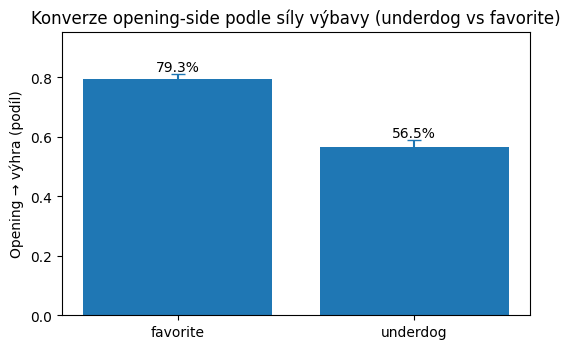

In [89]:
# Opening kill: "underdog loadout" → lepší konverze na výhru?
# (samostatné: tabulka, Fisher χ², OR+CI, graf, Markdown závěr)
import json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# ---------- 1) Loadout agregace (1 řádek = tým v kole) ----------
rl = read_df("""
  SELECT match_id, demo_file, round, team, has_helmet, inventory_json
  FROM round_loadouts
  WHERE team IN ('CT','T')
""")

def parse_items(s):
    try: return [str(x).lower() for x in json.loads(s)]
    except:   return []

# Kategorie (substring match)
AWP   = {"awp"}
RIFLE = {"ak-47","ak47","ak","m4a1-s","m4a1s","m4a1","m4a4","famas","galil ar","galil","aug","sg 553","sg553"}
SMG   = {"mp9","mac-10","mac10","mp7","mp5-sd","mp5sd","ump-45","ump45","p90"}
HEAVY = {"nova","xm1014","mag-7","mag7","sawed-off","sawed off","m249","negev"}
PIST  = {"glock-18","glock","usp-s","usps","p2000","p250","fiveseven","five-seven","tec-9","tec9","cz75-auto","cz75a","dual berettas","desert eagle","deagle","r8 revolver","revolver"}

def any_of(tokens, items):  return any(any(tok in it for tok in tokens) for it in items)
def count_of(tokens, items): return sum(1 for it in items if any(tok in it for tok in tokens))

agg=[]
for (mid, dem, rnd, team), g in rl.groupby(["match_id","demo_file","round","team"], dropna=False):
    items   = sum((parse_items(x) for x in g["inventory_json"]), [])
    helmets = int(pd.to_numeric(g["has_helmet"], errors="coerce").fillna(0).sum())
    players = int(len(g))
    agg.append(dict(
        match_id=mid, demo_file=dem, round=rnd, team=team,
        awp=int(any_of(AWP, items)),
        rifles=count_of(RIFLE, items),
        smgs=count_of(SMG, items),
        heavy=count_of(HEAVY, items),
        pistols=count_of(PIST, items),
        helmets=helmets, players=players
    ))
load = pd.DataFrame(agg)

# Kompozitní "síla výbavy" (relativní váhy, bez peněžních cen)
def load_score(df):
    return (6*df["awp"] + 3*df["rifles"] + 1.5*df["smgs"] + 1.5*df["heavy"] + 0.5*df["pistols"] + 0.75*df["helmets"])
load["score"] = load_score(load)

# ---------- 2) Opening-side, winner, spojení obou týmů v kole ----------
first = read_df("""
WITH first_tick AS (
  SELECT match_id, demo_file, round, MIN(tick) AS first_tick
  FROM kills_slim
  GROUP BY match_id, demo_file, round
)
SELECT k.match_id, k.demo_file, k.round, k.killerSide AS opening_side
FROM kills_slim k
JOIN first_tick f
  ON k.match_id=f.match_id AND k.demo_file=f.demo_file AND k.round=f.round AND k.tick=f.first_tick
""")
rnd = read_df("SELECT match_id, demo_file, round, LOWER(winner) AS winner FROM rounds")

ds = (first.merge(rnd, on=["match_id","demo_file","round"], how="inner")
           .assign(open_team=lambda d: d["opening_side"].map({"ct":"CT","t":"T"}),
                   other_team=lambda d: d["opening_side"].map({"ct":"T","t":"CT"}))
           .merge(load, left_on=["match_id","demo_file","round","open_team"],
                        right_on=["match_id","demo_file","round","team"], how="left")
           .rename(columns={c:f"{c}_open" for c in ["awp","rifles","smgs","heavy","pistols","helmets","players","score"]})
           .merge(load, left_on=["match_id","demo_file","round","other_team"],
                        right_on=["match_id","demo_file","round","team"], how="left")
           .rename(columns={c:f"{c}_other" for c in ["awp","rifles","smgs","heavy","pistols","helmets","players","score"]})
     )

# Δscore = opening − other; label = vyhrála opening-side?
ds["d_score"] = ds["score_open"] - ds["score_other"]
ds["opening_won"] = (ds["winner"] == ds["opening_side"]).astype(bool)

# Kategorizace: underdog/favorite (parita ignorujeme, ať je kontrast čistý)
thr = 0.0  # můžeš zkusit i +/−1 pro robustnost
flt = ds.dropna(subset=["d_score","opening_won"]).copy()
flt = flt.assign(state=lambda d: np.where(d["d_score"] < -thr, "underdog",
                                   np.where(d["d_score"] > thr, "favorite", "even")))
XY = flt.query("state != 'even'").copy()

# ---------- 3) 2×2 tabulka + testy ----------
tab = pd.crosstab(XY["state"]=="underdog", XY["opening_won"])
tab = tab.reindex(index=[False,True], columns=[False,True], fill_value=0)  # False=favorite, True=underdog
a = int(tab.loc[ True, True]); b = int(tab.loc[ True, False])
c = int(tab.loc[False, True]); d = int(tab.loc[False, False])

# OR (underdog vs favorite), 95% CI (Haldane–Anscombe)
aa,bb,cc,dd = map(float, (a,b,c,d))
if min(aa,bb,cc,dd)==0: aa+=0.5; bb+=0.5; cc+=0.5; dd+=0.5
OR = (aa*dd)/(bb*cc)
se = np.sqrt(1/aa + 1/bb + 1/cc + 1/dd)
lo, hi = np.exp(np.log(OR)-1.96*se), np.exp(np.log(OR)+1.96*se)

# Fisher exact: jednostranný „underdog má vyšší konverzi“ + dvoustranný
p_two = fisher_exact(tab.values, alternative="two-sided")[1]
p_greater = fisher_exact(tab.values, alternative="greater")[1]  # H1: underdog konvertuje lépe

chi2, p_chi2, dof, exp = chi2_contingency(tab.values)

# Míry s Wilson CI
def wilson(k, n, z=1.96):
    if n<=0: return (np.nan,np.nan,np.nan)
    p=k/n; den=1+z**2/n
    ctr=(p+z**2/(2*n))/den
    half=z*np.sqrt(p*(1-p)/n + z**2/(4*n**2))/den
    return p, ctr-half, ctr+half

und_n = int(tab.loc[True].sum()); fav_n = int(tab.loc[False].sum())
und_k = int(tab.loc[True,True]);   fav_k = int(tab.loc[False,True])
und_p, und_lo, und_hi = wilson(und_k, und_n)
fav_p, fav_lo, fav_hi = wilson(fav_k, fav_n)

# ---------- 4) Výstup (tabulky + graf) ----------
pd.options.display.float_format = "{:,.3f}".format

pretty = tab.copy()
pretty.index  = ["favorite","underdog"]
pretty.columns= ["Opening prohrál","Opening vyhrál"]
pretty["Σ řádek"] = pretty.sum(axis=1)
pretty.loc["Σ sloupec"] = pretty.sum()
print("2×2 tabulka (state × opening_won):")
print(pretty.to_string(), "\n")

rates = pd.DataFrame({
    "n":[fav_n, und_n],
    "win":[fav_k, und_k],
    "rate":[fav_p, und_p],
    "CI_lo":[fav_lo, und_lo],
    "CI_hi":[fav_hi, und_hi],
}, index=["favorite","underdog"])
print("Konverze opening-side (Wilson 95% CI):")
print(rates.assign(**{
    "rate(%)":  lambda d: d["rate"]*100,
    "CI_lo(%)": lambda d: d["CI_lo"]*100,
    "CI_hi(%)": lambda d: d["CI_hi"]*100,
}).drop(columns=["rate","CI_lo","CI_hi"]).to_string(), "\n")

print(f"OR (underdog vs favorite) = {OR:.2f}  (95% CI {lo:.2f}–{hi:.2f})")
print(f"Fisher p(one-sided, underdog>favorite) = {p_greater:.3e} | p(two-sided) = {p_two:.3e}")
print(f"Chi² p = {p_chi2:.3e}\n")

# Graf: konverzní míry + 95% CI
labels = ["favorite","underdog"]
vals   = [fav_p, und_p]
yerr   = [[vals[0]-fav_lo, vals[1]-und_lo],[fav_hi-vals[0], und_hi-vals[1]]]
plt.figure(figsize=(5.5,3.6))
plt.bar(labels, vals)
plt.errorbar(range(2), vals, yerr=yerr, fmt='none', capsize=5)
plt.ylabel("Opening → výhra (podíl)")
plt.title("Konverze opening-side podle síly výbavy (underdog vs favorite)")
for i,v in enumerate(vals):
    plt.text(i, v+(yerr[1][i] if np.isfinite(yerr[1][i]) else 0)+0.01, f"{v*100:.1f}%", ha='center')
plt.ylim(0, max(vals)*1.2 if all(np.isfinite(vals)) else 1)
plt.tight_layout(); plt.show()

### Závěr
- Konverze: **favorite 79.32%** (95% CI 77.58–80.96) vs **underdog 56.46%** (95% CI 54.02–58.87).
- **OR (underdog vs favorite) = 0.34** (95% CI **0.29–0.39**).
- Fisher **two-sided p = 1.55×10⁻⁵¹**, χ² **p = 1.377×10⁻⁵¹** → **zamítáme H₀ (rovnost)**.
- Fisher **one-sided (underdog > favorite) p = 1.000** → **hypotézu „underdog je lepší“ nepodporujeme** (data ukazují opak).

**Shrnutí:** Opening kill **konvertuje výrazně lépe u favorita** se silnější výbavou; u underdoga jsou odds výhry ~**o 66 % nižší**.

---

## Analýzy kolem

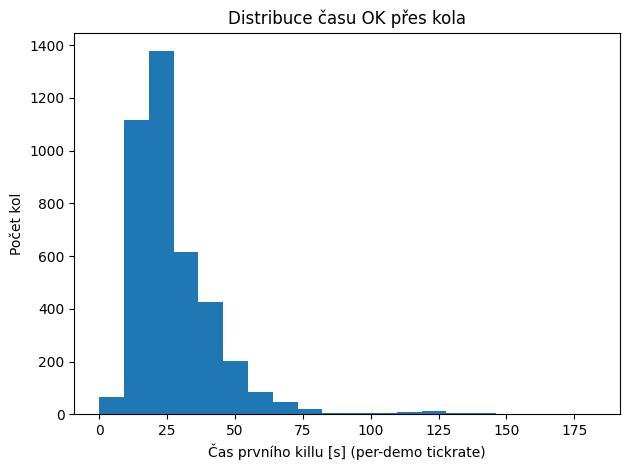

n=3999, median=22.34s, Q1=17.65s, Q3=33.83s


In [90]:
# OK timing (ticky -> sekundy) s tickrate z headeru
tickrate_default = float(get_tickrate_default())

ok_timing = read_df("""
WITH fk AS (
  SELECT r.match_id, r.demo_file, r.map_name, r.round,
         MIN(k.tick) AS first_tick,
         r.start AS round_start
  FROM rounds r
  JOIN kills_slim k
    ON (r.match_id=k.match_id AND r.demo_file=k.demo_file AND r.round=k.round)
  GROUP BY r.match_id, r.demo_file, r.map_name, r.round, r.start
)
SELECT f.map_name, f.match_id, f.demo_file,
       (f.first_tick - f.round_start) AS first_tick_rel,
       h.tickrate
FROM fk f
LEFT JOIN header h USING(match_id, demo_file)
""")



if not ok_timing.empty:
    tr = pd.to_numeric(ok_timing["tickrate"], errors="coerce").fillna(float(get_tickrate_default()))
    sec = ok_timing["first_tick_rel"].astype(float) / tr

    ax = sec.plot.hist(bins=20)
    ax.set_xlabel("Čas prvního killu [s] (per-demo tickrate)")
    ax.set_ylabel("Počet kol")
    ax.set_title("Distribuce času OK přes kola")
    plt.tight_layout(); plt.show()

    print(f"n={len(sec)}, median={sec.median():.2f}s, Q1={sec.quantile(0.25):.2f}s, Q3={sec.quantile(0.75):.2f}s")
else:
    print("OK timing: žádná data.")

## Kdy padá první kill (čas do OK od startu kola)
> Měříme čas od **startu kola** do prvního killu; ticky převádíme per-demo **tickrate** (z `header`).

**Výsledky (n = 3 999 kol):**
- **Medián = 22.34 s**, **IQR = 17.65–33.83 s**.
- **75 %** kol má opening kill do **33.83 s**. Rozdělení je **pravostranně šikmé** s řídkým „pozdním“ ocasem.

**Interpretace:**
- Většina kol má **časný kontakt** (OK do ~30 s), což odpovídá standardním výběhům a rychlým set-upům.
- Dlouhý pravý ocas ukazuje menšinu **pomalejších defaultů** a vyčkávacích kol.
- Prakticky: plánování na **rychlé trade okno** dává největší smysl v prvních **≈30 s** od startu kola.

---

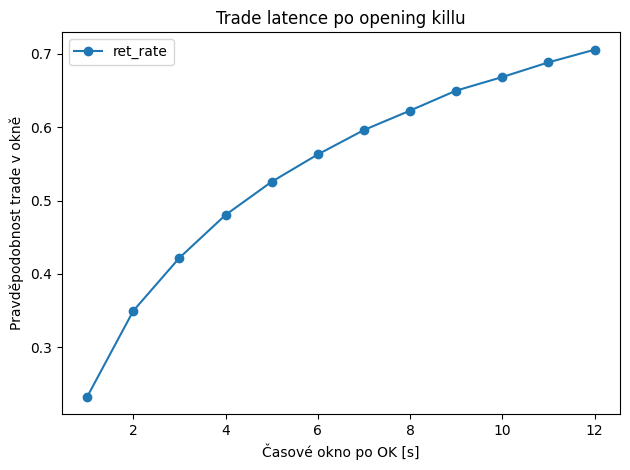

P(trade ≤ 1s) = 0.232
P(trade ≤ 3s) = 0.422
P(trade ≤ 5s) = 0.526
P(trade ≤ 10s) = 0.668


In [91]:
# Trade latence: pravděpodobnost, že do T sekund od OK přijde trade opačnou stranou
tickrate_default = float(get_tickrate_default())

ks = read_df("SELECT match_id, demo_file, round, tick, killerSide FROM kills_slim")
hdr = read_df("SELECT match_id, demo_file, tickrate FROM header")

def trade_curve_fast(ks: pd.DataFrame, hdr: pd.DataFrame, T_max=12) -> pd.DataFrame:
    if ks.empty:
        return pd.DataFrame(columns=["T","ret_rate"])

    df = ks.copy()
    df["killerSide"] = df["killerSide"].str.lower()

    # první kill v kole
    fk = (df.sort_values("tick")
            .groupby(["match_id","demo_file","round"], as_index=False)
            .first()
            .rename(columns={"tick":"t0","killerSide":"side0"}))

    # připoj tickrate per demo (fallback na default)
    fk = fk.merge(hdr, on=["match_id","demo_file"], how="left")
    fk["tickrate"] = pd.to_numeric(fk["tickrate"], errors="coerce").fillna(tickrate_default).astype(float)

    # všechny pozdější killy opačné strany v tomtéž kole
    jj = (df.merge(fk, on=["match_id","demo_file","round"], how="inner"))
    jj = jj[(jj["tick"] > jj["t0"]) & (jj["killerSide"] != jj["side0"])]

    # minimální delta času do prvního proti-killu v kole
    if jj.empty:
        n_rounds = len(fk)
        return pd.DataFrame({"T": np.arange(1, T_max+1), "ret_rate": np.zeros(T_max)})

    jj["dt_sec"] = (jj["tick"] - jj["t0"]) / jj["tickrate"]
    dt_min = (jj.groupby(["match_id","demo_file","round"], as_index=False)["dt_sec"]
                .min()
                .rename(columns={"dt_sec":"dt_min_sec"}))

    # připoj na všechny kola (kde trade není, necháme NaN)
    fk2 = fk.merge(dt_min, on=["match_id","demo_file","round"], how="left")

    # vektorizovaně spočítat ret_rate(T): P(dt_min <= T)
    n_rounds = len(fk2)
    vals = fk2["dt_min_sec"].to_numpy()
    vals = vals[np.isfinite(vals)]  # jen kola, která měla trade (ostatní > T vždy False)
    vals.sort()

    Ts = np.arange(1, T_max+1, dtype=float)
    # pro každé T kolik dt_min <= T (binary search)
    idx = np.searchsorted(vals, Ts, side="right")
    ret_rate = idx / float(n_rounds)
    return pd.DataFrame({"T": Ts, "ret_rate": ret_rate})

curve = trade_curve_fast(ks, hdr, T_max=12)
if not curve.empty:
    ax = curve.plot(x="T", y="ret_rate", marker="o")
    ax.set_xlabel("Časové okno po OK [s]")
    ax.set_ylabel("Pravděpodobnost trade v okně")
    ax.set_title("Trade latence po opening killu")
    plt.tight_layout(); plt.show()

    # pár rychlých čísel
    for T in (1,3,5,10):
        v = float(curve.loc[curve["T"].eq(T), "ret_rate"].iloc[0])
        print(f"P(trade ≤ {T}s) = {v:.3f}")
else:
    print("Trade křivka: žádná data.")

## Trade latence po opening killu
> Kumulativní pravděpodobnost, že do **T** sekund po opening killu přijde **trade** opačnou stranou.

**Výsledky:**
- P(trade ≤ **1 s**) = **0.232**
- P(trade ≤ **3 s**) = **0.422**
- P(trade ≤ **5 s**) = **0.526**
- P(trade ≤ **10 s**) = **0.668**

**Interpretace:**
- Zhruba **polovina** opening killů je tradovaná do **~5 s**, **dvě třetiny** do **~10 s**.
- Křivka je **konkávní** → největší riziko tradeu je v prvních **3–5 s**, poté tempo nárůstu slábne.

**Praktický takeaway:**
- Po získání OK se vyplatí **okamžitě ztížit trade** (ustoupit, změnit úhel, smoke/flash/molotov).
- Bez OK je potřeba **rychlá koordinovaná snaha o trade** právě v okně **do 3–5 s**.

---


# Závěr

**Hlavní otázka:** Má opening kill zásadní vliv na výsledek kola a jak do toho promlouvá výbava a kontext kola?

## Shrnutí klíčových zjištění

- **Opening kill ⟶ výhra kola (celkem):** velmi silný efekt.
  2×2 tabulka: winner×opening_side → **OR = 4.95** (95% CI 4.35–5.64), χ² p ≈ 2.4×10⁻¹³⁵, Fisher p ≈ 4.3×10⁻¹³⁹.
  Strana s opening killem vyhrála **≈ 69 %** kol.

- **Kdy padá první kill:** čas od startu kola do OK je **rychlý** – **medián 22.3 s**, IQR **17.7–33.8 s**.
  Většina kol má první kontakt do ~30 s; dlouhý pravý ocas reprezentuje pomalejší defaulty.

- **Trade latence po OK:**
  P(trade ≤ **1 s**) = **0.232**, ≤ **3 s** = **0.422**, ≤ **5 s** = **0.526**, ≤ **10 s** = **0.668**.
  → **Polovina** OK je tradovaná do ~**5 s**, **dvě třetiny** do ~**10 s**. Největší riziko tradeu je v prvních **3–5 s**.

- **CT vs T vyrovnanost (celkem):** **T-rate 51.3 %**, binomický test **p = 0.11** → **neodmítáme 50/50**.
  Per-map: **de_anubis** výrazně T-sided (p<0.001), **de_inferno** CT-sided (p<0.01); ostatní mapy nevýznamné.

- **Bomb plant prodlužuje kolo:** medián **57.9 s** (plant) vs **46.0 s** (bez plantu), **p ≪ 10⁻¹⁰**.

- **Helma snižuje riziko headshotu:** HS-rate **bez helmy 57.7 %** vs **s helmou 47.2 %**, χ² p ≈ 8×10⁻⁶⁴, Fisher p ≈ 4.9×10⁻⁶⁴.

- **AWP a opening/konverze:**
  - Přítomnost **AWP** zvyšuje šanci být **opening-side**: **OR = 1.34**, p ≈ 2.2×10⁻¹⁰ (Fisher ≈ 2.0×10⁻¹⁰).
  - **AWP u opening-side** zvyšuje **konverzi** na výhru: **OR = 1.29**, p ≈ 3.4×10⁻⁴.

- **„Underdog“ výbava a konverze:** pokud opening side začne **slabší výbavou** (kompozitní *loadout score*), konvertuje hůře:
  **OR = 0.34** (95% CI 0.29–0.39), χ² p ≈ 1.4×10⁻⁵¹; Fisher (two-sided) p ≈ 1.6×10⁻⁵¹.
  → Naopak **favorit** se silnější výbavou výrazně častěji dotlačí kolo do výhry.

## Odpověď na hlavní otázku

- **Ano.** Opening kill je **největší singulární faktor** úspěchu kola, konzistentně napříč mapami (síla efektu se liší).
- Výsledek ale **moduluje kontext**:
  - **Výbava** (AWP, celková „síla“ loadoutu) opening efekt **zesiluje**.
  - **Trade okno** je krátké – řízení rizika v prvních **3–5 s** po OK je klíčové.
  - Stranový bias **celkově vyrovnaný**, mapově však existují **významné odchylky**.

## Praktické dopady (pro interpretaci/strategii)

- Po získání OK **okamžitě snížit trade-risk** (ustoupit, přehrát úhel, utility) – nejděsivější je okno **do 5 s**.
- **AWP** má měřitelnou hodnotu v **zisku OK** i **konverzi** – obzvlášť v kolech s rovnou/lehce slabší zbytkovou výbavou.
- **Helmy** se vyplácejí: markantní snížení pravděpodobnosti smrti headshotem.
- Pro **underdoga** ani OK sám o sobě nestačí; je nutná **rychlá weapon pickup/upgrade** nebo **okamžitý tradovatelný postup**.

## Limity a hrozby validity

- **Loadout snapshot** je po freeze; nezachytí 100 % drop/pickup dynamiky během kola.
- **Kategorizace výbavy** je token-based (bez cen/equip value); zvolená vážení pro *score* jsou heuristika.
- **Per-map** testy mimo výslovně korigované tabulky nejsou korigované na vícenásobné testování.
- Nezohledňujeme **skill/elo týmů**, server/turnajový kontext a přesné **role** hráčů.

## Možné pokračování

- Vzít **ekonomickou hodnotu** (equip value) a modelovat konverzi OK s **kvantitativními delty** (místo heuristického score).
- **Per-map/per-site** modely (A/B na dané mapě) a **čas-do-plant** jako kovariáta.
- **Causal** přístupy (matching / IPTW) pro robustnější odhad dopadu AWP/helm/SMG apod.

---

**Celkový obrázek:**
*Opening kill dramaticky naklání kolo; kdo ho získá a zároveň má kompetitivní výbavu, vyhrává ve velké většině případů. Tempo tradeů ukazuje, že rozhoduje prvních pár sekund. Mapy se liší, ale základní mechanika je univerzální: **získej OK, nenech se hned tradnout, a výbavou podpoř konverzi**.*


---

### Co dál (nápady na rozšíření)
- Rozdělit kola na **full/force/eco** (heuristiky z loadoutu) a replikovat analýzy.
- Granáty: **flash nadčasování** (před/po OK), „smoke first“ a jejich souvislost s OK/konverzí.
- Prostorově: **heatmapy** prvních kontaktů a oblastí častých trade.

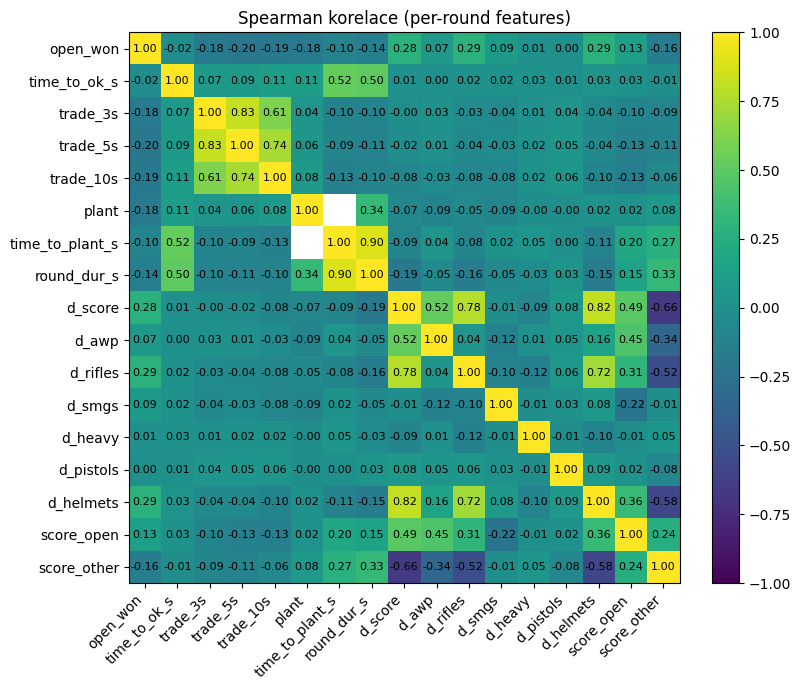

In [92]:
# Korelační heatmapa (per-round features) – čistý Matplotlib, Spearman
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- Pomocné ----
def read(sql): return read_df(sql)  # tvoje utilita
TICK_DEF = float(get_tickrate_default())

def parse_items(s):
    try: return [str(x).lower() for x in json.loads(s)]
    except: return []

AWP   = {"awp"}
RIFLE = {"ak-47","ak47","ak","m4a1-s","m4a1s","m4a1","m4a4","famas","galil ar","galil","aug","sg 553","sg553"}
SMG   = {"mp9","mac-10","mac10","mp7","mp5-sd","mp5sd","ump-45","ump45","p90"}
HEAVY = {"nova","xm1014","mag-7","mag7","sawed-off","sawed off","m249","negev"}
PIST  = {"glock-18","glock","usp-s","usps","p2000","p250","fiveseven","five-seven","tec-9","tec9","cz75-auto","cz75a","dual berettas","desert eagle","deagle","r8 revolver","revolver"}

def any_of(tokens, items):  return any(any(tok in it for tok in tokens) for it in items)
def count_of(tokens, items): return sum(1 for it in items if any(tok in it for tok in tokens))
def load_score(row):        return (6*row["awp"] + 3*row["rifles"] + 1.5*row["smgs"] + 1.5*row["heavy"] + 0.5*row["pistols"] + 0.75*row["helmets"])

# ---- Zdroje dat ----
hdr = read("SELECT match_id, demo_file, tickrate FROM header")
rnd = read("SELECT match_id, demo_file, round, start, end, LOWER(winner) AS winner FROM rounds")
ks  = read("SELECT match_id, demo_file, round, tick, LOWER(killerSide) AS killerSide FROM kills_slim")
bomb= read("SELECT match_id, demo_file, round, LOWER(event) AS event, t_sec FROM events_bomb")
rl  = read("""
  SELECT match_id, demo_file, round, team, has_helmet, inventory_json
  FROM round_loadouts WHERE team IN ('CT','T')
""")

# ---- First kill (čas a strana) ----
fk = (ks.sort_values("tick")
        .groupby(["match_id","demo_file","round"], as_index=False)
        .first()
        .rename(columns={"tick":"t0","killerSide":"opening_side"}))

# Per-demo tickrate
fk = (fk.merge(hdr, on=["match_id","demo_file"], how="left")
        .assign(tickrate=lambda d: pd.to_numeric(d["tickrate"], errors="coerce").fillna(TICK_DEF)))

# Čas do OK od startu kola
fk = fk.merge(rnd[["match_id","demo_file","round","start"]], on=["match_id","demo_file","round"], how="left")
fk["time_to_ok_s"] = (fk["t0"] - fk["start"]) / fk["tickrate"]

# ---- Trade latence (nejbližší proti-kill v s) ----
jj = ks.merge(fk[["match_id","demo_file","round","t0","opening_side","tickrate"]],
              on=["match_id","demo_file","round"], how="inner")
jj = jj[(jj["tick"] > jj["t0"]) & (jj["killerSide"] != jj["opening_side"])]
dt_min = (jj.assign(dt_sec=(jj["tick"]-jj["t0"]) / jj["tickrate"])
            .groupby(["match_id","demo_file","round"], as_index=False)["dt_sec"].min()
            .rename(columns={"dt_sec":"dt_trade_min_s"}))
fk = fk.merge(dt_min, on=["match_id","demo_file","round"], how="left")
fk["trade_3s"]  = (fk["dt_trade_min_s"] <= 3).astype(float).fillna(0.0)
fk["trade_5s"]  = (fk["dt_trade_min_s"] <= 5).astype(float).fillna(0.0)
fk["trade_10s"] = (fk["dt_trade_min_s"] <= 10).astype(float).fillna(0.0)

# ---- Bomb plant flag + čas do plantu ----
planted = (bomb.query("event=='planted'")
             .groupby(["match_id","demo_file","round"], as_index=False)
             .first()[["match_id","demo_file","round","t_sec"]]
             .rename(columns={"t_sec":"time_to_plant_s"}))
fk = fk.merge(planted, on=["match_id","demo_file","round"], how="left")
fk["plant"] = (~fk["time_to_plant_s"].isna()).astype(float)

# ---- Délka kola v sekundách ----
rnd = rnd.merge(hdr, on=["match_id","demo_file"], how="left")
rnd["round_dur_s"] = (rnd["end"] - rnd["start"]) / pd.to_numeric(rnd["tickrate"], errors="coerce").fillna(TICK_DEF)

# ---- Loadout agregace po týmech (per round) ----
agg = []
for (mid, dem, rnd_id, team), g in rl.groupby(["match_id","demo_file","round","team"], dropna=False):
    items = sum((parse_items(x) for x in g["inventory_json"]), [])
    helmets = pd.to_numeric(g["has_helmet"], errors="coerce").fillna(0).sum()
    row = dict(match_id=mid, demo_file=dem, round=rnd_id, team=team,
               awp=int(any_of(AWP, items)),
               rifles=count_of(RIFLE, items),
               smgs=count_of(SMG, items),
               heavy=count_of(HEAVY, items),
               pistols=count_of(PIST, items),
               helmets=float(helmets))
    row["score"] = load_score(row)
    agg.append(row)
L = pd.DataFrame(agg)

# Opening vs protistrana + delty
ds = (fk.merge(rnd[["match_id","demo_file","round","winner","round_dur_s"]], on=["match_id","demo_file","round"], how="left")
        .assign(open_team=lambda d: d["opening_side"].map({"ct":"CT","t":"T"}),
                other_team=lambda d: d["opening_side"].map({"ct":"T","t":"CT"}))
        .merge(L, left_on=["match_id","demo_file","round","open_team"],
                  right_on=["match_id","demo_file","round","team"], how="left", suffixes=("","_open"))
        .rename(columns={"awp":"awp_open","rifles":"rifles_open","smgs":"smgs_open","heavy":"heavy_open","pistols":"pistols_open","helmets":"helmets_open","score":"score_open"})
        .merge(L, left_on=["match_id","demo_file","round","other_team"],
                  right_on=["match_id","demo_file","round","team"], how="left", suffixes=("","_other"))
        .rename(columns={"awp":"awp_other","rifles":"rifles_other","smgs":"smgs_other","heavy":"heavy_other","pistols":"pistols_other","helmets":"helmets_other","score":"score_other"})
     )

ds["open_won"] = (ds["winner"] == ds["opening_side"]).astype(float)
for c in ["awp","rifles","smgs","heavy","pistols","helmets","score"]:
    ds[f"d_{c}"] = pd.to_numeric(ds[f"{c}_open"], errors="coerce") - pd.to_numeric(ds[f"{c}_other"], errors="coerce")

# ---- Feature set pro korelaci ----
features = [
    "open_won",
    "time_to_ok_s", "trade_3s", "trade_5s", "trade_10s",
    "plant", "time_to_plant_s", "round_dur_s",
    "d_score","d_awp","d_rifles","d_smgs","d_heavy","d_pistols","d_helmets",
    "score_open","score_other"  # volitelné: i absolutní síla obou stran
]
X = ds[features].apply(pd.to_numeric, errors="coerce")
X = X.replace([np.inf,-np.inf], np.nan).dropna(how="all")  # necháme NaN kde nejsou planty apod.

# Spearman korelace (robustnější na nelinearity/početnosti)
corr = X.corr(method="spearman")

# ---- Heatmapa (Matplotlib) ----
fig, ax = plt.subplots(figsize=(9,7))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
ax.set_title("Spearman korelace (per-round features)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# volitelné: čísla do buněk
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.values[i,j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()
